In [1]:
!git clone  https://<username>:<token>@github.com/TeamEpochGithub/kenyan-sign-language.git

Cloning into 'kenyan-sign-language'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 190 (delta 17), reused 28 (delta 8), pack-reused 152
Receiving objects: 100% (190/190), 9.24 MiB | 21.96 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [2]:
%cd kenyan-sign-language
!git submodule update --init

/content/kenyan-sign-language
Submodule 'models/tensorflow/automl' (https://github.com/google/automl) registered for path 'models/tensorflow/automl'
Submodule 'src/hyperoptim/klrfinder' (https://github.com/magisterbrown/keras_lr_finder.git) registered for path 'src/hyperoptim/klrfinder'
Cloning into '/content/kenyan-sign-language/models/tensorflow/automl'...
Cloning into '/content/kenyan-sign-language/src/hyperoptim/klrfinder'...
Submodule path 'models/tensorflow/automl': checked out '0b0ba5ebd0860edd939465fc4152da4ff9f79b44'
Submodule path 'src/hyperoptim/klrfinder': checked out '8edce6e3baab909ffe508d445c2f8ccaa45c90df'


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
!pip3 install tensorflow-addons --quiet

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [5]:
import sys
sys.path.append("models/tensorflow/automl/efficientnetv2")

In [10]:
from effnetv2_model import get_model
import tensorflow as tf
from src.preprocessing.tf_dataset_parsers import TfLabler
from src.preprocessing.tf_dataset_parsers import TfSubmiter
from src.preprocessing.tf_dataset_parsers import TfParser
from src.preprocessing.tf_dataset_parsers import TfPresenter
from src.models.efficentnetV2 import EffiecntHead
from src.preprocessing.runtime_preprocessors import resize
from src.preprocessing.runtime_preprocessors import normalize
from src.preprocessing.runtime_preprocessors import randaugment_with_chioce
from autoaugment import distort_image_with_randaugment
import matplotlib.pyplot as plt

from src.results import generator
from src.results import cross_pred

from src.tpu import connect

In [7]:
available_ops = [
      'AutoContrast', 'Equalize', 'Invert', 'Rotate', 'Posterize',
      'Solarize', 'Color', 'Contrast', 'Brightness', 'Sharpness',
      'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Cutout', 'SolarizeAdd']

In [ ]:
strategy = connect()

In [28]:
augmenter = lambda x: distort_image_with_randaugment(x,3,8)
parser = TfLabler(processors=[normalize])
full = tf.data.TFRecordDataset("gs://chimps-first/data/signs.tfrecords").map(parser).shuffle(128, reshuffle_each_iteration=True).batch(64,drop_remainder=True)

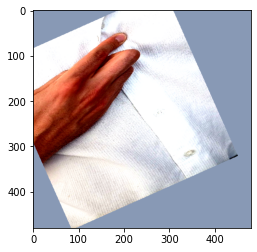

In [18]:
itt = iter(full)
img = next(itt)[0].numpy()[0]
plt.imshow(img*0.5+0.5)

In [19]:
pretrained_ckpt = tf.train.latest_checkpoint('gs://chimps-first/efficientnetv2-s-21k')

In [22]:

def init_model():
  tf.keras.backend.clear_session()
  with strategy.scope():
    eff_back = get_model(model_name='efficientnetv2-s',weights=None,include_top=False, training=True)
    model = EffiecntHead(1500,0.0,eff_back)
    model.load_back(pretrained_ckpt)

   

    model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.442),
    loss=tf.keras.losses.SparseCategoricalCrossentropy())

  return model

In [25]:
#  scheduer = tf.keras.optimizers.schedules.CosineDecay(
#       0.0437, 10*24, alpha=0.081, name=None
#     )

In [23]:
model = init_model()

In [29]:
history = model.fit(
  full, epochs=2,verbose=True
)

Epoch 1/2
97/97 [==============================] - 18s 183ms/step - loss: 0.9763
Epoch 2/2
97/97 [==============================] - 18s 180ms/step - loss: 0.5750


#Save weights

In [37]:
import os
model.save_weights(os.path.join('.', 'effnet.h5'), overwrite=True)

# Submission

In [30]:
authtoken = "KHkJpqasteMDQGYAAgaBM2xe"
!wget --post-data="auth_token=$authtoken" https://api.zindi.africa/v1/competitions/kenyan-sign-language-classification-challenge/files/SampleSubmission.csv -q

In [31]:
subcs = pd.read_csv("SampleSubmission.csv",index_col=0)
subcs.head(3)

,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
img_IDS,,,,,,,,,
ImageID_USRB8QNG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ImageID_SZ8D1ZJI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ImageID_4OJO2F8J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
subm = TfSubmiter(processors=[normalize])
submit = tf.data.TFRecordDataset("gs://chimps-first/data/tosubmit.tfrecords").map(subm).batch(32)

In [33]:
subcs = generator(submit,model,subcs)

49


In [34]:
subcs.tail(3)

,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
img_IDS,,,,,,,,,
ImageID_0IBAU19T,0.992969,0.002824,0.000297,0.000020,0.000157,0.000617,0.000094,0.002684,0.000338
ImageID_K6IAGP77,0.000308,0.000172,0.592064,0.398248,0.005921,0.000446,0.000131,0.002617,0.000093
ImageID_IKQQPMCC,0.000299,0.000204,0.014128,0.433298,0.550861,0.000145,0.000055,0.000644,0.000365


In [35]:
subcs.to_csv("subm.csv")

In [36]:

from google.colab import files
files.download('subm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>